# Install libraries

In [1]:
!python --version

Python 3.9.12


In [2]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [50]:
import pickle

# Read in data

In [4]:
path_to_data_green_jan_2021 = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet'
path_to_data_green_feb_2021 = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet'

In [5]:
# Read in the data
df = pd.read_parquet(path_to_data_green_jan_2021)

In [6]:
df.head(2)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75


# Pre-process the data

In [7]:
# Convert pickup and dropoff columns from str to datetime
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime']) 
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])

In [8]:
# Create the duration column
df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']

# Get the duration in minutes
df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)

In [9]:
df.head(2)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000


In [10]:
# Filter the trip type
# df = df[df['trip_type'] == 2]

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


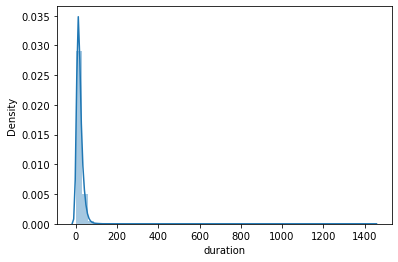

In [11]:
# Take a look at the distributin of duration
sns.distplot(df['duration']);

# To do: 
# 1. Create a nice visualisation of duration

In [12]:
# Summary stats 
df['duration'].describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

In [13]:
# Notice the outlier. Look at the percentiles
df['duration'].describe(percentiles=[0.95, 0.98, 0.99])

# Focus on durations >1min and <60mins

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [14]:
# Check how many observations satisfy the condition
((df['duration'] >= 1) & (df['duration'] <= 60)).mean()

# ~96% -> ok

0.9658903787344154

In [15]:
df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

# Feature Engineering

In [16]:
# Column names
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'duration'],
      dtype='object')

In [17]:
# Specify categorical and numerical variables
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [18]:
# Encoding categorical variables
df[categorical].dtypes

# To use One-Hot Encoding (OHE), we can use Dictionary Vectorizer.
# Dictionary Vectorizer treats everything which is not a number as a categorical variable and encodes it.
# Here, however, both PULocationID and DOLocationID are integers -> cast them into strings

PULocationID    int64
DOLocationID    int64
dtype: object

In [19]:
df[categorical] = df[categorical].astype(str)

In [20]:
# DictVectorizer requires a dictionary as an input. 
# Convert variables into a dictionary
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [21]:
# Create feature matrix that will be used to train the model
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [22]:
X_train

<73908x507 sparse matrix of type '<class 'numpy.float64'>'
	with 221724 stored elements in Compressed Sparse Row format>

In [23]:
# Check how OHE worked
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [24]:
# Create the target variable values
target = 'duration'
y_train = df[target].values

In [25]:
y_train

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ])

# Fit Linear Regression model

In [26]:
# Fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [27]:
# Create predictions on the training set
y_pred = lr.predict(X_train)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


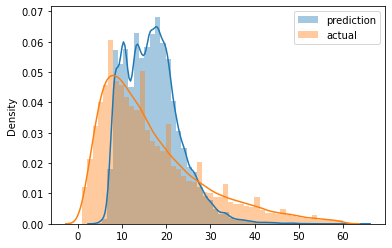

In [28]:
# Visualise predictions vs actual data
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()
plt.show();

# Evaluate the fitted model

In [29]:
# Calculate the error
# squared=False calculates the root of the squared error
mean_squared_error(y_train, y_pred, squared=False)

# On average the model is wrong by ~9 minutes

9.775464552087287

# Automating the Pre-processing Step

In [31]:
def read_dataframe(filename):
    # Read in the data
    df = pd.read_parquet(filename)
    
    # Create a pre-processing function
    # Convert pickup and dropoff columns from str to datetime
    df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime']) 
    df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])

    # Create the duration column
    df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']

    # Get the duration in minutes
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)

    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

    # Specify categorical and numerical variables
    categorical = ['PULocationID', 'DOLocationID']

    df[categorical] = df[categorical].astype(str)
    
    return df

In [32]:
path_to_data_green_jan_2021 = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet'
path_to_data_green_feb_2021 = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet'

# Model Validation

In [33]:
# Create train and validation datasets
df_train = read_dataframe(path_to_data_green_jan_2021)
df_val = read_dataframe(path_to_data_green_feb_2021)

In [34]:
# Size of the datasets
len(df_train), len(df_val)

(73908, 61921)

In [43]:
# Create a new feature - PU and DO combination
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [44]:
categorical = ['PU_DO'] # ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts) # Why do we only do transform here?

In [45]:
# Create the target variable values
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [52]:
# Fit the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Create predictions on the validation set
y_pred = lr.predict(X_val)

# Calculate the error
mean_squared_error(y_val, y_pred, squared=False)

7.479562160810692

In [47]:
# Fit the Lasso Linear Regression model
lr = Lasso()
lr.fit(X_train, y_train)

# Create predictions on the validation set
y_pred = lr.predict(X_val)

# Calculate the error
mean_squared_error(y_val, y_pred, squared=False)

12.212583224318818

In [48]:
# Fit the Lasso Linear Regression model - change alpha
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)

# Create predictions on the validation set
y_pred = lr.predict(X_val)

# Calculate the error
mean_squared_error(y_val, y_pred, squared=False)

9.233436225720547

In [49]:
# Fit the Ridge Linear Regression model 
lr = Ridge()
lr.fit(X_train, y_train)

# Create predictions on the validation set
y_pred = lr.predict(X_val)

# Calculate the error
mean_squared_error(y_val, y_pred, squared=False)

11.342603943250333

In [53]:
# Save the model
# wb mode = write binary
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)